In [ ]:
# Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
from keras.preprocessing import image
from keras.models import Sequential
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

In [ ]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 30
# Fitting the Model
FILE_PATH="/content/sample_data"

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 534 files belonging to 6 classes.


In [ ]:
class_name = dataset.class_names
class_name

['.ipynb_checkpoints',
 'Primary Endo with Secondary Perio',
 'Primary Endodontic Lesion',
 'Primary Perio with Secondary Endo',
 'Primary Periodontal Lesion',
 'True Combined Lesions']

In [ ]:
len(dataset) # Number of batches

17

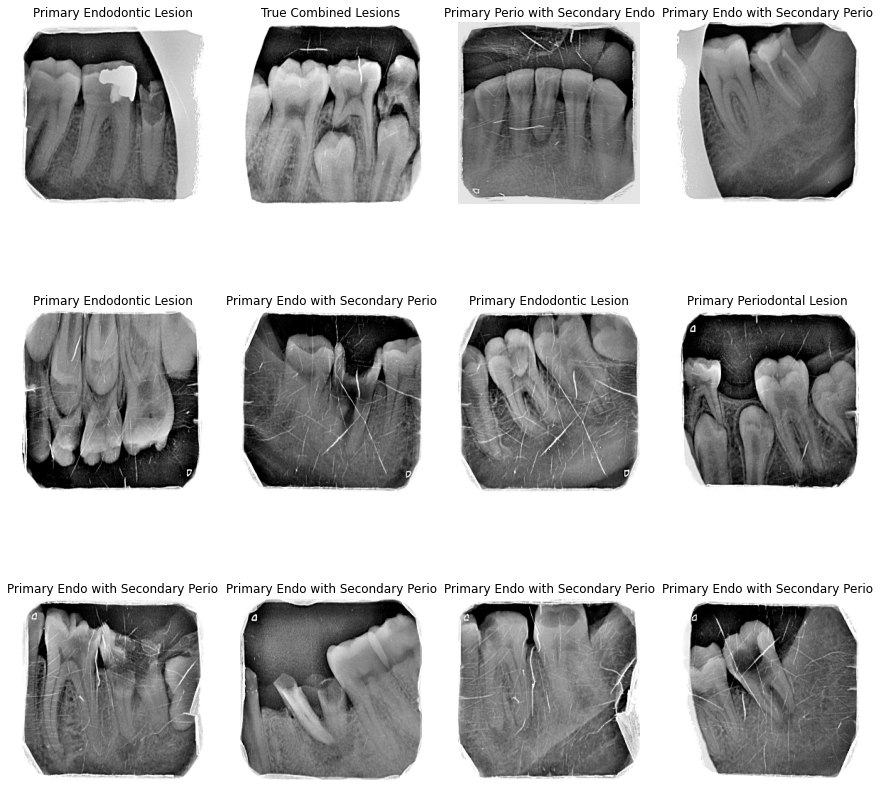

In [ ]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1): 
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_name[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph

In [ ]:
def get_dataset_partitions(ds, train_split = .8, val_split= .1, test_split=.1, shuffle = True, shuffle_size = 10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    ds_size = len(ds)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size+ val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(13, 1, 3)

In [ ]:
# caching,shuffle and prefetching the data
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
     layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
       layers.Dense(128, activation = 'relu'),
          layers.Dense(128, activation = 'relu'),
             layers.Dense(128, activation = 'relu'),
                layers.Dense(128, activation = 'relu'),
                  layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax')
      
    
])
model.build(input_shape= input_shape)

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_17 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_80 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_80 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [ ]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(train_ds,
         epochs= EPOCHS,
         batch_size= BATCH_SIZE,
         verbose= 1,
         validation_data= val_ds)
history = model.fit(train_ds,
         epochs= EPOCHS,
         batch_size= BATCH_SIZE,
         
         verbose= 1,
         validation_data= val_ds)


Epoch 1/30
13/13 [==============================] - 1s 100ms/step - loss: 1.5252 - accuracy: 0.2709 - val_loss: 1.4867 - val_accuracy: 0.3750
Epoch 2/30
13/13 [==============================] - 1s 98ms/step - loss: 1.5350 - accuracy: 0.2931 - val_loss: 1.4984 - val_accuracy: 0.3438
Epoch 3/30
13/13 [==============================] - 1s 99ms/step - loss: 1.5361 - accuracy: 0.2857 - val_loss: 1.4724 - val_accuracy: 0.3125
Epoch 4/30
13/13 [==============================] - 1s 98ms/step - loss: 1.5271 - accuracy: 0.2833 - val_loss: 1.4566 - val_accuracy: 0.2812
Epoch 5/30
13/13 [==============================] - 1s 99ms/step - loss: 1.5240 - accuracy: 0.2906 - val_loss: 1.4747 - val_accuracy: 0.3750
Epoch 6/30
13/13 [==============================] - 1s 99ms/step - loss: 1.5028 - accuracy: 0.2783 - val_loss: 1.4723 - val_accuracy: 0.3125
Epoch 7/30
13/13 [==============================] - 1s 107ms/step - loss: 1.5276 - accuracy: 0.2833 - val_loss: 1.4731 - val_accuracy: 0.3750
Epoch 8/30


In [ ]:

scores = model.evaluate(test_ds)

First Image of batch to predict :
Actual label :  True Combined Lesions
1/1 [==============================] - 0s 152ms/step
Predicted label :  True Combined Lesions


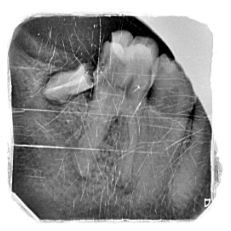

In [ ]:
#plotting image
for batch_image, batch_label in train_ds.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

In [ ]:
def oral_cancer(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence =  dental(model, images[i])
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
!mkdir models